In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import logging
import argparse
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from itertools import product
from scipy.spatial import Delaunay

In [2]:
# truth PF

# Code

In [2]:
from tqdm import trange

In [3]:
import functions_hv_grad_3d

In [4]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv

In [5]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv


def evaluate_hv(soluong, start, end, net, ref_point,Problem,n_obj,problem_name):
    #print('Evaluate')
    results = []
    net.eval()
    # rays = np.c_[x, y]
    rays = circle_points(soluong, dim=n_obj)
    # min_penalty = 999
    for i in range(soluong):
        ray = rays[i]
        ray /= ray.sum()
        ray = torch.from_numpy(
            ray.astype(np.float32).flatten()
        ).to(device)

        # weights = hnet(ray)
        output = net(ray)[0]
        L = Problem._evaluate(output)
        loss_batch = L.detach().cpu().numpy()
        loss_batch = np.array(loss_batch)
        #loss_mean = np.mean(loss_batch, axis=0)
        # penalty = np.sum(rays[i].astype(np.float32).flatten() * loss_batch) / (np.sqrt(np.sum(loss_batch ** 2)))
        # if penalty < min_penalty:
            # min_penalty = penalty
        results.append(loss_batch)

    results = np.array(results, dtype='float32')
    # if n_obj > 0:
    #     ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=3)
    #     if problem_name == 'dtlz5':
    #         pf = get_problem(problem_name).pareto_front()
    #     else:
    #         pf = get_problem(problem_name).pareto_front(ref_dirs)
    #     ind = IGD(pf)
    #     return ind(results), results
    # else:
    return compute_hv(results.T, ref_point), results

In [6]:
def evenly_dist_weights(num_weights, dim):
    return [ret for ret in product(
        np.linspace(0.0, 1.0, num_weights), repeat=dim) if
            round(sum(ret), 3) == 1.0 and all(r not in (0.0, 1.0) for r in ret)]

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, dim,n_task=3,out_dim=10, **kwargs):
        super().__init__()
        self.tasks = n_task
        self.MLP = nn.Sequential(
            nn.Linear(n_task, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
        )
        self.f = nn.Sequential(
            nn.Linear(dim[0], 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
        )
        self.w = nn.Linear(100, 100)
        self.b = nn.Linear(100, 100)
        for j in range(self.tasks):
            setattr(self, f"task_{j}_weights", nn.Linear(100, out_dim))

    def forward(self,alpha):
        x = torch.ones([1, 1], dtype=torch.float32).to(device)
        feature = self.MLP(alpha)
        x = self.f(x)
        x = self.w(feature) * x + self.b(feature)
        output = []
        for j in range(self.tasks):
            output.append(F.sigmoid(getattr(self, f"task_{j}_weights")(x)))
        return output

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
def obj_func(X_, g, n_obj, alpha=1):
    f = []

    for i in range(0, n_obj):
        _f = (1 + g)
        _f *= torch.prod(torch.cos(torch.pow(X_[:, :X_.shape[1] - i], alpha) * torch.pi / 2.0), axis=1)
        if i > 0:
            _f *= torch.sin(torch.pow(X_[:, X_.shape[1] - i], alpha) * torch.pi / 2.0)

        f.append(_f)

    f = torch.column_stack(f)
    return f

def g2(X_M):
    return torch.sum(torch.square(X_M - 0.5), axis=1)
    

class DTLZ2:
    def __init__(self, n_var, n_obj):
        self.n_obj = n_obj
        self.n_var= n_var
        self.dim = n_obj
        self.k = self.dim - self.n_obj + 1
        self.bounds = torch.tensor([(0.0, 1.0) for _ in range(self.dim)])
        self.ref_point = torch.tensor([-1.1 for _ in range(self.n_obj)])
    def _evaluate(self, x):
        out= {}
        X_ = x[:, :self.n_obj - 1]
        X_M = x[:, self.n_obj - 1:]
        g = g2(X_M)
        out["F"] = obj_func(X_, g, self.n_obj, alpha=1)
        return out['F'][0]
    
class DTLZ5:
    def __init__(self, n_var, n_obj):
        self.n_obj = n_obj
        self.n_var= n_var

    def _evaluate(self, x):
        out= {}
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = g2(X_M)

        theta = 1 / (2 * (1 + g[:, None])) * (1 + 2 * g[:, None] * X_)
        theta = torch.column_stack([x[:, 0], theta[:, 1:]])
        out["F"] = obj_func(theta, g, self.n_obj)
        return out['F'][0]

In [10]:
import random


def set_logger():
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO
    )


def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [11]:
set_logger()

In [12]:
class parse_arg():
    def __init__(self):
        pass


args = parse_arg()
args.no_cuda = False
args.gpus = '0'

In [13]:
def get_device(no_cuda=False, gpus='0'):
    return torch.device(f"cuda:{gpus}" if torch.cuda.is_available() and not no_cuda else "cpu")


device = get_device(no_cuda=args.no_cuda, gpus=args.gpus)
#device=get_device(no_cuda=True)

In [14]:
from functions_evaluation import fastNonDominatedSort

In [15]:
import copy
from _utils import num_parameters, circle_points
from functions_hv_python3 import HyperVolume

# Trainer

In [16]:
from pymoo.factory import get_reference_directions

In [17]:
from functions_evaluation import compute_hv_in_higher_dimensions as compute_hv
import pymc3 as pm
import sys
from MCTS import mcts

2023-05-16 12:17:57,035 - theano.tensor.blas - WARNING - Using NumPy C-API based implementation for BLAS functions.


In [18]:
import copy
def train(device: torch.device, hidden_dim: int, lr: float, wd: float, epochs: int, alpha: float, 
          hesophat: float,Problem,ref,n_var=10, n_obj=3,problem_name='dtlz'):
    test_rays = get_reference_directions("das-dennis", 3, n_partitions=5).astype(
        np.float32
    )
    training = []
    dim = list((1, ))
    # dim[0] = dim[0] + 2
    net = FullyConnected(dim=dim,out_dim=n_var,n_task=n_obj)
    # net = Toy_Hypernetwork(ray_hidden_dim=hidden_dim, n_tasks=1)
    best_hv = 0
    
    logging.info(f"HN size: {count_parameters(net)}")

    net = net.to(device)
    _Problem = Problem(n_var = n_var,n_obj=n_obj)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    stop = 0
    hv = 0
    best_net = None
    mc_agent = None
    best_hv = 0
    stop =0
    dem = 0
    num = 0
    Outputs = []
    loss_torch_per_sample = []
    Rays = []
    epoch_iter = trange(epochs)
    cir_rays = circle_points(20, dim=n_obj)
    for epoch in epoch_iter:
        dem += 1
        net.train()
        optimizer.zero_grad()
        loss_numpy_per_sample = []
        loss_per_sample = []
        weights = []

        if epoch % 500 ==0 and epoch!=0:
            HV, result = evaluate_hv(soluong=100, start= 0., end=np.pi / 2, net=net, ref_point=ref, Problem=_Problem,n_obj=n_obj,problem_name=problem_name)
            if HV > best_hv:
                print('HV:', HV)
                best_net = copy.deepcopy(net)
                best_hv = HV
                stop = 0
            else:
                stop += 1
        if stop==2:
            break
        if epoch < 20:
            
            ray = cir_rays[num]
            ray /= np.sum(ray)
            ray = ray.astype(np.float32)
            rays= torch.from_numpy(
            ray.flatten()).to(device)
            num += 1
        else:
            # MCTS
            if mc_agent is None:
                ray, mc_agent = mcts(_Problem, [torch.tensor(Outputs), torch.tensor(loss_torch_per_sample),
                                                torch.tensor(Rays)], net)
            else:
                ray = mc_agent.search(net)
            rays = ray.to(torch.float32).flatten()
            print('MCTS_ray:', rays)

        

        
        outputs = net(rays)[0]
        Loss_list = _Problem._evaluate(outputs)
        Loss_list = [i for i in Loss_list]
        loss_per_sample = torch.stack(Loss_list)
        
        Rays.append(rays.cpu().detach().squeeze(0).tolist())
        Outputs.append(outputs.cpu().detach().squeeze(0).tolist())
        loss_torch_per_sample.append(loss_per_sample.cpu().detach().squeeze(0).tolist())
        
        d2 = torch.linalg.norm(torch.cross((rays), loss_per_sample)/torch.linalg.norm(loss_per_sample))

        z = torch.tensor([0] * len(rays)).to(loss_per_sample.device)
        d1 = torch.sqrt(torch.dist(loss_per_sample, z)**2 - d2**2)
        tch_reward  = hesophat* d1 + (1-hesophat) * d2

        tch_reward.backward()
        optimizer.step()

    return best_net

In [19]:
unit = np.linspace(0, 1, 6)
n_tasks = 3
vector = [0] * n_tasks
rays_vector = []
rays_vector = get_reference_directions("das-dennis", 3, n_partitions=5).astype(
    np.float32
)

rays_sampling = np.array(rays_vector)
rays_vector_2 = np.delete(rays_sampling, -1, axis=1)
tri = Delaunay(rays_vector_2)
partition = tri.simplices
partition = partition.astype(np.int32)

/tmp/ipykernel_387459/743211191.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) get_reference_directions. (Please use `from pymoo.util.ref_dirs import get_reference_directions`)
  rays_vector = get_reference_directions("das-dennis", 3, n_partitions=5).astype(


In [20]:
def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [21]:
from pymoo.indicators.igd import IGD
device = get_device(no_cuda=args.no_cuda, gpus=args.gpus)
hidden_dim = 100
lr = 1e-1
wd = 0.
epochs = 300
alpha = 1.
hesophat = 0.5  #lamda
method = "4_MH"
n_var=10
n_obj=3
ref=[1.1] * n_obj
name = "dtlz2"

In [22]:
import warnings
warnings.filterwarnings("ignore")
set_seed(1)
net = train(device = get_device(no_cuda=args.no_cuda, gpus=args.gpus), hidden_dim=100,
                  lr=1e-3, wd=0., epochs=epochs, alpha=1 , hesophat=hesophat,Problem=DTLZ2, ref=ref,n_var=n_var, n_obj=n_obj, problem_name=name);

  4%|▍         | 13/300 [00:00<00:02, 128.77it/s]

==========collect 20 points for initializing MCTS==========
lb: [0. 0. 0.]
ub: [1. 1. 1.]
Cp: 6
inits: 10
dims: 3


  9%|▊         | 26/300 [00:01<00:14, 19.45it/s] 

current iteration botorch hv is 0.19067838788032532
total nodes: 1
==>to split: [0]  total: 1
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:20/20     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:True    val:0.1870          uct:9.0440         sp/n:11/11     bound:0.0>0.55 0.3>1.0 0.0>0.52                              parent:node0      kids:
node2  is good:False  is leaf:True    val:0.1700          uct:9.9610         sp/n:9/9       bound:0.03>0.81 0.04>0.27 0.04>0.72                          parent:node0      kids:
----------------------------------------------------------------------------------------------------
time = 0.01.

=> node2 1 

node samples are not svm splittable
stage1: time = 0.00.cur_node is node0 7482
total sampled: 7483
stage

 11%|█         | 33/300 [00:01<00:12, 20.61it/s]

continue split: True
==>to split: [1]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:31/31     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:16/16     bound:0.0>0.73 0.17>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:True    val:0.2010          uct:8.3210         sp/n:15/15     bound:0.09>0.81 0.01>0.28 0.03>0.72                          parent:node0      kids:
node3  is good:True   is leaf:True    val:0.1810          uct:9.6000         sp/n:9/9       bound:0.0>0.45 0.38>1.0 0.0>0.52                             parent:node1      kids:
node4  is good:False  is leaf:True    val:0.1560          uct:10.8360        sp/n

 13%|█▎        | 38/300 [00:01<00:13, 19.71it/s]

current iteration botorch hv is 0.25277209281921387
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:35/35     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:18/18     bound:0.0>0.73 0.12>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:17/17     bound:0.06>0.81 0.01>0.29 0.03>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   is leaf:True    val:0.1850          uct:9.3090         sp/n:10/10     bound:0.0>0.45 0.31>1.0 0.0>0.52                  

 14%|█▍        | 42/300 [00:01<00:13, 18.98it/s]

cur_node is node0 4563
cur_node is node2 2310
total sampled: 2311
stage2: time = 0.01.hv in each iter is [0.282656192779541, 6.163376808166504]
MCTS_ray: tensor([0.6488, 0.3422, 0.0090], device='cuda:0')
current iteration botorch hv is 0.2995145916938782
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:39/39     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:20/20     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:19/19     bound:0.04>0.77 0.01>0.34 0.01>0.75         

 15%|█▌        | 45/300 [00:02<00:14, 18.19it/s]

current iteration botorch hv is 0.30437374114990234
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:42/42     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:22/22     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:20/20     bound:0.04>0.77 0.01>0.34 0.01>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   is leaf:True    val:0.1870          uct:8.8000         sp/n:12/12     bound:0.0>0.55 0.27>1.0 0.0>0.52                  

 16%|█▌        | 48/300 [00:02<00:14, 17.17it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:45/45     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:23/23     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:22/22     bound:0.04>0.77 0.01>0.34 0.01>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   is leaf:True    val:0.1870          uct:8.8620         sp/n:12/12     bound:0.0>0.55 0.27>1.0 0.0>0.52                             parent:node1      kids:
node4  is good:False  is leaf:True    val:0.1830          uct:9.2440         sp/n:11/11     bound:0.03>0.81 0

 17%|█▋        | 51/300 [00:02<00:15, 16.20it/s]

continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:48/48     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:25/25     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:23/23     bound:0.04>0.91 0.01>0.34 0.01>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   is leaf:True    val:0.1880          uct:8.6320         sp/n:13/13     bound:0.0>0.55 0.22>1.0 0.0>0.52                             parent:node1      kids:
node4  is good:False  is leaf:True    val:0.1870          u

 18%|█▊        | 53/300 [00:02<00:16, 15.38it/s]

current iteration botorch hv is 0.3164049983024597
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:51/51     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:26/26     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:25/25     bound:0.04>0.91 0.01>0.34 0.01>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   is leaf:True    val:0.1880          uct:8.3750         sp/n:14/14     bound:0.0>0.55 0.22>1.0 0.0>0.72                   

 18%|█▊        | 55/300 [00:02<00:16, 14.53it/s]

hv in each iter is [0.31972551345825195, 6.417325973510742]
MCTS_ray: tensor([0.8386, 0.1271, 0.0342], device='cuda:0')
current iteration botorch hv is 0.32656723260879517
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:54/54     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:28/28     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:26/26     bound:0.04>0.91 0.02>0.34 0.01>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   

 19%|█▉        | 57/300 [00:03<00:17, 13.73it/s]

continue split: True
==>to split: [1 2]  total: 3
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:56/56     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:29/29     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:27/27     bound:0.04>0.91 0.02>0.34 0.01>0.75                          parent:node0      kids:node5     node6     
node3  is good:True   is leaf:True    val:0.1890          uct:8.2300         sp/n:15/15     bound:0.0>0.73 0.22>1.0 0.0>0.72                             parent:node1      kids:
node4  is good:False  is leaf:True    val:0.1990          u

 20%|█▉        | 59/300 [00:03<00:18, 12.81it/s]

cur_node is node0 7233
cur_node is node1 5894
cur_node is node3 121
total sampled: 122
stage2: time = 0.02.hv in each iter is [0.39273303747177124, 6.760950088500977]
MCTS_ray: tensor([0.2246, 0.3547, 0.4207], device='cuda:0')
current iteration botorch hv is 0.39997950196266174
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:59/59     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:30/30     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:in

 20%|██        | 61/300 [00:03<00:19, 12.20it/s]

hv in each iter is [0.4100523293018341, 6.804269313812256]
MCTS_ray: tensor([0.2250, 0.3564, 0.4186], device='cuda:0')
current iteration botorch hv is 0.4119199812412262
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 5]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:61/61     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:31/31     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:30/30     bound:0.04>0.91 0.0>0.36 0.01>0.94                           parent:node0      

 21%|██        | 63/300 [00:03<00:21, 11.18it/s]

hv in each iter is [0.41420242190361023, 6.811738014221191]
MCTS_ray: tensor([0.4864, 0.2659, 0.2478], device='cuda:0')
current iteration botorch hv is 0.4143998324871063
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 5]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:63/63     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:32/32     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:31/31     bound:0.04>0.91 0.0>0.78 0.01>0.94                           parent:node0     

 22%|██▏       | 65/300 [00:03<00:22, 10.54it/s]

hv in each iter is [0.4148307740688324, 6.841700553894043]
MCTS_ray: tensor([0.7470, 0.1594, 0.0936], device='cuda:0')
current iteration botorch hv is 0.4303889274597168
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:65/65     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:33/33     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:32/32     bound:0.04>0.91 0.0>0.78 0.01>0.94                           parent:node0    

 22%|██▏       | 67/300 [00:04<00:23, 10.08it/s]

hv in each iter is [0.4311891794204712, 6.842272758483887]
MCTS_ray: tensor([0.5741, 0.3280, 0.0979], device='cuda:0')
current iteration botorch hv is 0.4312937259674072
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:67/67     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:34/34     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:33/33     bound:0.04>0.91 0.0>0.78 0.01>0.94                           parent:node0  

 23%|██▎       | 70/300 [00:04<00:24,  9.26it/s]

cur_node is node0 9610
cur_node is node1 6136
cur_node is node3 811
total sampled: 812
stage2: time = 0.02.hv in each iter is [0.4320603609085083, 6.844603061676025]
MCTS_ray: tensor([0.0055, 0.3151, 0.6794], device='cuda:0')
current iteration botorch hv is 0.43406128883361816
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:69/69     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:35/35     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             u

 24%|██▍       | 72/300 [00:04<00:25,  8.79it/s]

continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:70/70     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:36/36     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:34/34     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:19/19     bound:0.0>0.73 0.07>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False

 24%|██▍       | 73/300 [00:04<00:26,  8.44it/s]

current iteration botorch hv is 0.43700486421585083
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:72/72     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:37/37     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:35/35     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:19/19 

 25%|██▌       | 75/300 [00:05<00:28,  7.96it/s]

hv in each iter is [0.4386628270149231, 6.854891777038574]
MCTS_ray: tensor([0.1316, 0.2708, 0.5976], device='cuda:0')
current iteration botorch hv is 0.43964672088623047
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:74/74     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:38/38     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:36/36     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0 

 26%|██▌       | 77/300 [00:05<00:29,  7.66it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:75/75     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:38/38     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:37/37     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:20/20     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:18/18  

 26%|██▌       | 78/300 [00:05<00:29,  7.42it/s]

current iteration botorch hv is 0.44457948207855225
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:77/77     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:39/39     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:38/38     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:20/20 

 27%|██▋       | 80/300 [00:05<00:30,  7.14it/s]

cur_node is node0 9500
cur_node is node1 5996
cur_node is node3 530
total sampled: 531
stage2: time = 0.02.hv in each iter is [0.4455794095993042, 6.86497688293457]
MCTS_ray: tensor([0.4359, 0.1920, 0.3721], device='cuda:0')
current iteration botorch hv is 0.44629305601119995
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:79/79     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:40/40     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uc

 27%|██▋       | 81/300 [00:06<00:31,  7.02it/s]

current iteration botorch hv is 0.4466744661331177
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:80/80     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:41/41     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:39/39     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:21/21  

 28%|██▊       | 83/300 [00:06<00:31,  6.88it/s]

cur_node is node0 6683
cur_node is node2 3994
cur_node is node5 1050
total sampled: 1051
stage2: time = 0.02.hv in each iter is [0.4467502236366272, 6.86782693862915]
MCTS_ray: tensor([0.3646, 0.0410, 0.5944], device='cuda:0')
current iteration botorch hv is 0.4470011591911316
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:82/82     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:42/42     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             u

 28%|██▊       | 84/300 [00:06<00:32,  6.72it/s]

current iteration botorch hv is 0.44702035188674927
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:83/83     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:42/42     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:41/41     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:22/22 

 28%|██▊       | 85/300 [00:06<00:32,  6.65it/s]

cur_node is node0 5475
cur_node is node2 4829
cur_node is node5 1399
total sampled: 1400
stage2: time = 0.02.hv in each iter is [0.4541878402233124, 6.88996696472168]
MCTS_ray: tensor([0.4575, 0.0468, 0.4957], device='cuda:0')
current iteration botorch hv is 0.4548851251602173
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7


 29%|██▊       | 86/300 [00:06<00:40,  5.29it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:85/85     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:43/43     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:42/42     bound:0.01>0.91 0.0>0.78 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:22/22     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:21/21  

 29%|██▉       | 88/300 [00:07<00:37,  5.67it/s]

hv in each iter is [0.4556732773780823, 6.895610809326172]
MCTS_ray: tensor([0.1836, 0.8111, 0.0052], device='cuda:0')
current iteration botorch hv is 0.4568867087364197
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:87/87     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:44/44     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:43/43     bound:0.01>0.91 0.0>0.81 0.01>0.94                           parent:node0  

 30%|██▉       | 89/300 [00:07<00:36,  5.78it/s]

current iteration botorch hv is 0.4569535255432129
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:88/88     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:45/45     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:43/43     bound:0.01>0.91 0.0>0.81 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:23/23  

 30%|███       | 90/300 [00:07<00:36,  5.79it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:89/89     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:45/45     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:44/44     bound:0.01>0.91 0.0>0.81 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:23/23     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:22/22  

 30%|███       | 91/300 [00:07<00:36,  5.78it/s]

cur_node is node1 6039
cur_node is node3 496
total sampled: 497
stage2: time = 0.03.hv in each iter is [0.45706653594970703, 6.89661979675293]
MCTS_ray: tensor([0.7683, 0.0719, 0.1598], device='cuda:0')
current iteration botorch hv is 0.45726609230041504
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:91/91     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:46/46     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:

 31%|███       | 93/300 [00:08<00:35,  5.78it/s]

hv in each iter is [0.45726609230041504, 6.9118757247924805]
MCTS_ray: tensor([0.4206, 0.5615, 0.0179], device='cuda:0')
current iteration botorch hv is 0.46332961320877075
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:92/92     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:47/47     bound:0.0>0.82 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:45/45     bound:0.01>0.91 0.0>0.81 0.01>0.94                           parent:node

 31%|███▏      | 94/300 [00:08<00:35,  5.75it/s]

current iteration botorch hv is 0.46476656198501587
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:93/93     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:47/47     bound:0.0>0.82 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:46/46     bound:0.01>0.91 0.0>0.81 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:24/24 

 32%|███▏      | 95/300 [00:08<00:36,  5.64it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:94/94     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:48/48     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:46/46     bound:0.01>0.85 0.0>0.81 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:25/25     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:23/23  

 32%|███▏      | 96/300 [00:08<00:36,  5.61it/s]

cur_node is node0 5692
cur_node is node2 2741
cur_node is node6 1418
total sampled: 1419
stage2: time = 0.03.hv in each iter is [0.4659425616264343, 6.922492504119873]
MCTS_ray: tensor([0.1863, 0.0529, 0.7608], device='cuda:0')
current iteration botorch hv is 0.4663265347480774
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:96/96     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:49/49     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             

 32%|███▏      | 97/300 [00:08<00:37,  5.47it/s]

stage2: time = 0.04.hv in each iter is [0.4663265347480774, 6.923825740814209]
MCTS_ray: tensor([0.3451, 0.1964, 0.4584], device='cuda:0')
current iteration botorch hv is 0.4664178192615509
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:97/97     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:49/49     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:48/48     bound:0.01>0.85 0.0>0.81 0.01>0.94                     

 33%|███▎      | 99/300 [00:09<00:37,  5.36it/s]

hv in each iter is [0.4664178192615509, 6.926366806030273]
MCTS_ray: tensor([0.4848, 0.3914, 0.1238], device='cuda:0')
current iteration botorch hv is 0.4679417610168457
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:98/98     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:50/50     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:48/48     bound:0.01>0.85 0.0>0.81 0.01>0.94                           parent:node0  

 33%|███▎      | 100/300 [00:09<00:37,  5.32it/s]

current iteration botorch hv is 0.4713849127292633
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:99/99     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:50/50     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:49/49     bound:0.01>0.85 0.0>0.81 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:26/26  

 34%|███▎      | 101/300 [00:09<00:37,  5.28it/s]

continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:100/100   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:51/51     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:49/49     bound:0.01>0.85 0.0>0.81 0.01>0.94                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:26/26     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node1      kids:node7 

 34%|███▍      | 102/300 [00:09<00:38,  5.18it/s]

continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:101/101   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:51/51     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:50/50     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:26/26     bound:0.0>0.81 0.04>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False

 34%|███▍      | 103/300 [00:10<00:40,  4.86it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:102/102   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:52/52     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:50/50     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:27/27     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:25/25  

 35%|███▍      | 104/300 [00:10<00:40,  4.90it/s]

continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:103/103   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:52/52     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:51/51     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:27/27     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node1      kids:node7 

 35%|███▌      | 105/300 [00:10<00:41,  4.66it/s]

continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:104/104   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:53/53     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:51/51     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:27/27     bound:0.0>0.81 0.01>1.0 0.0>0.72                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False

 35%|███▌      | 106/300 [00:10<00:41,  4.67it/s]

current iteration botorch hv is 0.5334089398384094
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:105/105   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:53/53     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:52/52     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:27/27  

 36%|███▌      | 107/300 [00:10<00:41,  4.62it/s]

current iteration botorch hv is 0.5334553718566895
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:106/106   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:54/54     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:52/52     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:28/28  

 36%|███▌      | 108/300 [00:11<00:41,  4.60it/s]

current iteration botorch hv is 0.5360416173934937
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:107/107   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:54/54     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:53/53     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:28/28  

 36%|███▋      | 109/300 [00:11<00:43,  4.43it/s]

current iteration botorch hv is 0.5510995388031006
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:108/108   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:55/55     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:53/53     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:28/28  

 37%|███▋      | 110/300 [00:11<00:42,  4.42it/s]

current iteration botorch hv is 0.5554081201553345
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:109/109   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:55/55     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:54/54     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:28/28  

 37%|███▋      | 111/300 [00:11<00:42,  4.46it/s]

current iteration botorch hv is 0.5558626651763916
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:110/110   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:56/56     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:54/54     bound:0.01>0.85 0.0>0.81 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:29/29  

 37%|███▋      | 112/300 [00:12<00:42,  4.38it/s]

current iteration botorch hv is 0.5793114900588989
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:111/111   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:56/56     bound:0.0>0.91 0.01>1.0 0.0>0.75                             parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:55/55     bound:0.01>0.85 0.0>0.83 0.0>0.94                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:29/29  

 38%|███▊      | 113/300 [00:12<00:42,  4.36it/s]

current iteration botorch hv is 0.5793140530586243
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:112/112   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:57/57     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:55/55     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:29/29  

 38%|███▊      | 114/300 [00:12<00:43,  4.32it/s]

current iteration botorch hv is 0.5831208825111389
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:113/113   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:57/57     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:56/56     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:29/29  

 38%|███▊      | 115/300 [00:12<00:44,  4.18it/s]

current iteration botorch hv is 0.5837928652763367
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [7]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:114/114   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:58/58     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:56/56     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   va

 39%|███▊      | 116/300 [00:13<00:44,  4.15it/s]

current iteration botorch hv is 0.5861707329750061
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [7]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:115/115   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:58/58     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:57/57     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   va

 39%|███▉      | 117/300 [00:13<00:44,  4.11it/s]

current iteration botorch hv is 0.586479127407074
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [7]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:116/116   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:59/59     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:57/57     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val

 39%|███▉      | 118/300 [00:13<00:44,  4.06it/s]

current iteration botorch hv is 0.5877857208251953
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7 11]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:117/117   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:59/59     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:58/58     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False 

 40%|███▉      | 119/300 [00:13<00:45,  4.02it/s]

current iteration botorch hv is 0.5900970697402954
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7 11]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:118/118   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:60/60     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:58/58     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False 

 40%|████      | 120/300 [00:14<00:45,  3.97it/s]

current iteration botorch hv is 0.5902547836303711
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7 11]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:119/119   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:60/60     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:59/59     bound:0.01>0.85 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False 

 40%|████      | 121/300 [00:14<00:46,  3.88it/s]

current iteration botorch hv is 0.5942095518112183
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  9 11]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:120/120   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:61/61     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:59/59     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:Fal

 41%|████      | 122/300 [00:14<00:47,  3.75it/s]

current iteration botorch hv is 0.5954290628433228
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  9 11]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:121/121   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:61/61     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:60/60     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:Fal

 41%|████      | 123/300 [00:14<00:47,  3.73it/s]

current iteration botorch hv is 0.5954737067222595
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  9 11]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:122/122   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:62/62     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:60/60     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:Fal

 41%|████▏     | 124/300 [00:15<00:47,  3.72it/s]

current iteration botorch hv is 0.5954917073249817
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  9 11 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:123/123   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:62/62     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:61/61     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:

 42%|████▏     | 125/300 [00:15<00:47,  3.65it/s]

current iteration botorch hv is 0.5955032110214233
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  9 11 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:124/124   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:63/63     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:61/61     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:

 42%|████▏     | 126/300 [00:15<00:48,  3.61it/s]

current iteration botorch hv is 0.5965602397918701
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  9 11 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:125/125   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:63/63     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:62/62     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is leaf:

 42%|████▏     | 127/300 [00:15<00:48,  3.55it/s]

current iteration botorch hv is 0.5966042876243591
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 11 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:127/127   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:64/64     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:63/63     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is le

 43%|████▎     | 128/300 [00:16<00:49,  3.50it/s]

current iteration botorch hv is 0.5966172814369202
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 11 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:128/128   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:65/65     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:63/63     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is le

 43%|████▎     | 129/300 [00:16<00:49,  3.44it/s]

current iteration botorch hv is 0.6053444147109985
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 11 12 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:129/129   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:65/65     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:64/64     bound:0.01>0.87 0.02>0.83 0.0>0.88                           parent:node0      kids:node5     node6     
node3  is good:True   is

 43%|████▎     | 130/300 [00:16<00:50,  3.38it/s]

hv in each iter is [0.6053444147109985, 7.706185817718506]
MCTS_ray: tensor([0.4889, 0.0490, 0.4621], device='cuda:0')
current iteration botorch hv is 0.6159188747406006
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 11 12 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:130/130   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:66/66     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:64/64     bound:0.01

 44%|████▎     | 131/300 [00:17<00:50,  3.36it/s]

cur_node is node0 7943
cur_node is node1 5955
cur_node is node3 3383
cur_node is node7 177
total sampled: 178
stage2: time = 0.04.hv in each iter is [0.6159188747406006, 7.7068963050842285]
MCTS_ray: tensor([0.3321, 0.2556, 0.4123], device='cuda:0')
current iteration botorch hv is 0.6160504817962646
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 11 12 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:131/131   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:66/66     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0   

 44%|████▍     | 132/300 [00:17<00:50,  3.33it/s]

hv in each iter is [0.6160504817962646, 7.707634925842285]
MCTS_ray: tensor([0.1987, 0.0022, 0.7991], device='cuda:0')
current iteration botorch hv is 0.6205229759216309
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:132/132   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:67/67     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:65/65     bound:0

 44%|████▍     | 133/300 [00:17<00:50,  3.28it/s]

cur_node is node0 9182
cur_node is node1 7053
cur_node is node3 3060
cur_node is node8 2150
total sampled: 2151
stage2: time = 0.04.hv in each iter is [0.6205229759216309, 7.710925102233887]
MCTS_ray: tensor([0.4749, 0.1352, 0.3899], device='cuda:0')
current iteration botorch hv is 0.6233842968940735
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:133/133   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:67/67     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node

 45%|████▍     | 134/300 [00:18<00:50,  3.27it/s]

hv in each iter is [0.6233842968940735, 7.71096134185791]
MCTS_ray: tensor([0.8172, 0.1629, 0.0198], device='cuda:0')
current iteration botorch hv is 0.6234089732170105
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:134/134   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:68/68     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:66/66     bound:0.

 45%|████▌     | 135/300 [00:18<00:50,  3.24it/s]

cur_node is node0 6068
cur_node is node2 2776
cur_node is node5 1866
cur_node is node12 1253
total sampled: 1254
stage2: time = 0.04.hv in each iter is [0.6234089732170105, 7.712430000305176]
MCTS_ray: tensor([0.2490, 0.0763, 0.6747], device='cuda:0')
current iteration botorch hv is 0.6237266659736633
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:135/135   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:68/68     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:

 45%|████▌     | 136/300 [00:18<00:51,  3.19it/s]

hv in each iter is [0.6237266659736633, 7.718454360961914]
MCTS_ray: tensor([0.2674, 0.6592, 0.0735], device='cuda:0')
current iteration botorch hv is 0.6250261068344116
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:136/136   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:69/69     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:67/67     boun

 46%|████▌     | 137/300 [00:19<00:51,  3.16it/s]

cur_node is node0 9501
cur_node is node1 6388
cur_node is node3 3575
cur_node is node7 404
total sampled: 405
stage2: time = 0.05.hv in each iter is [0.6250261068344116, 7.7184648513793945]
MCTS_ray: tensor([0.3740, 0.2599, 0.3661], device='cuda:0')
current iteration botorch hv is 0.6250336766242981
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:137/137   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:69/69     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:no

 46%|████▌     | 138/300 [00:19<00:51,  3.14it/s]

hv in each iter is [0.6250336766242981, 7.724490165710449]
MCTS_ray: tensor([0.2889, 0.0973, 0.6137], device='cuda:0')
current iteration botorch hv is 0.6258115768432617
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:138/138   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:70/70     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:68/68     boun

 46%|████▋     | 139/300 [00:19<00:52,  3.08it/s]

cur_node is node0 4264
cur_node is node2 1771
cur_node is node5 332
cur_node is node11 332
total sampled: 333
stage2: time = 0.04.hv in each iter is [0.6258115768432617, 7.724968910217285]
MCTS_ray: tensor([0.1951, 0.7840, 0.0209], device='cuda:0')
current iteration botorch hv is 0.6260190010070801
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:139/139   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:70/70     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:nod

 47%|████▋     | 140/300 [00:20<00:53,  2.98it/s]

hv in each iter is [0.6260190010070801, 7.7250471115112305]
MCTS_ray: tensor([0.4186, 0.1908, 0.3906], device='cuda:0')
current iteration botorch hv is 0.6260856986045837
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:140/140   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:71/71     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:69/69     bou

 47%|████▋     | 141/300 [00:20<00:55,  2.86it/s]

cur_node is node0 4289
cur_node is node2 2795
cur_node is node6 2096
cur_node is node13 0
total sampled: 1
cur_node is node0 4348
cur_node is node2 2875
cur_node is node6 2102
total sampled: 2103
stage2: time = 0.08.hv in each iter is [0.6260856986045837, 7.7277913093566895]
MCTS_ray: tensor([0.1402, 0.6848, 0.1750], device='cuda:0')
current iteration botorch hv is 0.6267865300178528
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:141/141   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf           

 47%|████▋     | 142/300 [00:20<00:58,  2.71it/s]

hv in each iter is [0.6267865300178528, 7.728981018066406]
MCTS_ray: tensor([0.5484, 0.3055, 0.1462], device='cuda:0')
current iteration botorch hv is 0.6274691224098206
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 48%|████▊     | 143/300 [00:21<00:57,  2.75it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:142/142   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:72/72     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:70/70     bound:0.02>0.87 0.0>0.83 0.0>0.88                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:37/37     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:35/35  

 48%|████▊     | 144/300 [00:21<00:55,  2.79it/s]

hv in each iter is [0.6276959776878357, 7.7320556640625]
MCTS_ray: tensor([0.1543, 0.7415, 0.1041], device='cuda:0')
current iteration botorch hv is 0.6279734373092651
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 48%|████▊     | 145/300 [00:21<00:55,  2.79it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:144/144   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:73/73     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:71/71     bound:0.02>0.87 0.0>0.83 0.0>0.88                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:37/37     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:36/36  

 49%|████▊     | 146/300 [00:22<00:55,  2.80it/s]

hv in each iter is [0.6283032894134521, 7.732558250427246]
MCTS_ray: tensor([0.0232, 0.0070, 0.9698], device='cuda:0')
current iteration botorch hv is 0.6283557415008545
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 49%|████▉     | 147/300 [00:22<00:55,  2.76it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:146/146   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:74/74     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:72/72     bound:0.02>0.87 0.0>0.83 0.0>0.97                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:38/38     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:36/36  

 49%|████▉     | 148/300 [00:23<00:55,  2.73it/s]

hv in each iter is [0.6288682818412781, 7.733713150024414]
MCTS_ray: tensor([0.4248, 0.1930, 0.3823], device='cuda:0')
current iteration botorch hv is 0.6289329528808594
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 50%|████▉     | 149/300 [00:23<00:55,  2.72it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:148/148   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:75/75     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:73/73     bound:0.02>0.87 0.0>0.83 0.0>0.97                            parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:38/38     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:37/37  

 50%|█████     | 150/300 [00:23<00:55,  2.70it/s]

hv in each iter is [0.6295443773269653, 7.73715877532959]
MCTS_ray: tensor([6.6150e-04, 2.8705e-01, 7.1229e-01], device='cuda:0')
current iteration botorch hv is 0.6297253370285034
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 50%|█████     | 151/300 [00:24<00:55,  2.69it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:150/150   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:76/76     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:74/74     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:39/39     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:37/37  

 51%|█████     | 152/300 [00:24<00:55,  2.69it/s]

hv in each iter is [0.6297972798347473, 7.7388014793396]
MCTS_ray: tensor([0.0215, 0.7116, 0.2669], device='cuda:0')
current iteration botorch hv is 0.6298578381538391
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 51%|█████     | 153/300 [00:24<00:54,  2.68it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:152/152   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:77/77     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:75/75     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:39/39     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:38/38  

 51%|█████▏    | 154/300 [00:25<00:55,  2.62it/s]

hv in each iter is [0.6298817992210388, 7.740005970001221]
MCTS_ray: tensor([0.7995, 0.1111, 0.0894], device='cuda:0')
current iteration botorch hv is 0.6307087540626526
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 52%|█████▏    | 155/300 [00:25<00:56,  2.58it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:154/154   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:78/78     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:76/76     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:40/40     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:38/38  

 52%|█████▏    | 156/300 [00:26<00:56,  2.55it/s]

hv in each iter is [0.6307210326194763, 7.740018844604492]
MCTS_ray: tensor([0.4076, 0.2336, 0.3587], device='cuda:0')
current iteration botorch hv is 0.6307225823402405
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 52%|█████▏    | 157/300 [00:26<00:57,  2.50it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:156/156   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:79/79     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:77/77     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:40/40     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:39/39  

 53%|█████▎    | 158/300 [00:26<00:57,  2.47it/s]

hv in each iter is [0.6307769417762756, 7.740357398986816]
MCTS_ray: tensor([0.1329, 0.7999, 0.0672], device='cuda:0')
current iteration botorch hv is 0.6308222413063049
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 53%|█████▎    | 159/300 [00:27<00:57,  2.46it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:158/158   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:80/80     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:78/78     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:41/41     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:39/39  

 53%|█████▎    | 160/300 [00:27<00:56,  2.46it/s]

hv in each iter is [0.6319258809089661, 7.747498512268066]
MCTS_ray: tensor([0.8519, 0.0139, 0.1342], device='cuda:0')
current iteration botorch hv is 0.6337513327598572
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:160/160   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:81/81     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:79/79     boun

 54%|█████▎    | 161/300 [00:28<00:59,  2.32it/s]

hv in each iter is [0.6337513327598572, 7.750545501708984]
MCTS_ray: tensor([0.0342, 0.0019, 0.9639], device='cuda:0')
current iteration botorch hv is 0.6339064240455627
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 54%|█████▍    | 162/300 [00:28<00:58,  2.36it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:161/161   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:81/81     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:80/80     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:41/41     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:40/40  

 54%|█████▍    | 163/300 [00:29<00:57,  2.38it/s]

hv in each iter is [0.6339139342308044, 7.774004936218262]
MCTS_ray: tensor([0.2253, 0.6425, 0.1322], device='cuda:0')
current iteration botorch hv is 0.6367814540863037
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:163/163   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:82/82     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:81/81     boun

 55%|█████▍    | 164/300 [00:29<00:57,  2.36it/s]

hv in each iter is [0.6367814540863037, 7.77425479888916]
MCTS_ray: tensor([0.8341, 0.0384, 0.1275], device='cuda:0')
current iteration botorch hv is 0.6370807886123657
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15


 55%|█████▌    | 165/300 [00:29<00:57,  2.36it/s]

continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:164/164   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:83/83     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:81/81     bound:0.0>0.87 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:True   is leaf:False   val:inf             uct:inf            sp/n:42/42     bound:0.0>0.81 0.01>1.0 0.0>0.75                             parent:node1      kids:node7     node8     
node4  is good:False  is leaf:False   val:inf             uct:inf            sp/n:41/41  

 55%|█████▌    | 166/300 [00:30<00:57,  2.34it/s]

hv in each iter is [0.6372864246368408, 7.774415016174316]
MCTS_ray: tensor([0.6036, 0.2309, 0.1655], device='cuda:0')
current iteration botorch hv is 0.637288510799408
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:166/166   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:84/84     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:82/82     bound

 56%|█████▌    | 167/300 [00:30<00:57,  2.30it/s]

hv in each iter is [0.637288510799408, 7.774416923522949]
MCTS_ray: tensor([0.0623, 0.1128, 0.8249], device='cuda:0')
current iteration botorch hv is 0.6372930407524109
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:167/167   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:84/84     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:83/83     bound

 56%|█████▌    | 168/300 [00:31<01:04,  2.06it/s]

current iteration botorch hv is 0.6376079320907593
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:168/168   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:85/85     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:83/83     bound:0.0>0.89 0.0>0.83 0.0>0.97                             parent:node0      kids:node5     node6     
node3  is good:Tru

 56%|█████▋    | 169/300 [00:31<01:02,  2.10it/s]

hv in each iter is [0.6376079320907593, 7.774661064147949]
MCTS_ray: tensor([0.1732, 0.0125, 0.8143], device='cuda:0')
current iteration botorch hv is 0.6376085877418518
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:169/169   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:85/85     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:84/84     boun

 57%|█████▋    | 170/300 [00:32<01:00,  2.13it/s]

hv in each iter is [0.6376085877418518, 7.775054931640625]
MCTS_ray: tensor([0.6524, 0.1107, 0.2369], device='cuda:0')
current iteration botorch hv is 0.637886106967926
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:170/170   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:86/86     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:84/84     bound

 57%|█████▋    | 171/300 [00:32<00:59,  2.15it/s]

hv in each iter is [0.637886106967926, 7.775077819824219]
MCTS_ray: tensor([0.9411, 0.0350, 0.0239], device='cuda:0')
current iteration botorch hv is 0.6379052996635437
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:171/171   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:86/86     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:85/85     bound

 57%|█████▋    | 172/300 [00:33<00:59,  2.14it/s]

hv in each iter is [0.6379052996635437, 7.7758989334106445]
MCTS_ray: tensor([0.3855, 0.0118, 0.6027], device='cuda:0')
current iteration botorch hv is 0.6381409764289856
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:172/172   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:87/87     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:85/85     bou

 58%|█████▊    | 173/300 [00:33<00:59,  2.15it/s]

hv in each iter is [0.6381409764289856, 7.778115272521973]
MCTS_ray: tensor([0.5434, 0.3529, 0.1037], device='cuda:0')
current iteration botorch hv is 0.6391374468803406
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:173/173   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:87/87     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:86/86     boun

 58%|█████▊    | 174/300 [00:34<00:58,  2.16it/s]

hv in each iter is [0.6391374468803406, 7.778908729553223]
MCTS_ray: tensor([0.0878, 0.2610, 0.6511], device='cuda:0')
current iteration botorch hv is 0.6394831538200378
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:174/174   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:88/88     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:86/86     boun

 58%|█████▊    | 175/300 [00:34<00:57,  2.17it/s]

hv in each iter is [0.6394831538200378, 7.7833356857299805]
MCTS_ray: tensor([0.0683, 0.6297, 0.3020], device='cuda:0')
current iteration botorch hv is 0.6401109099388123
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:175/175   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:88/88     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:87/87     bou

 59%|█████▊    | 176/300 [00:35<00:57,  2.17it/s]

hv in each iter is [0.6401109099388123, 7.785009860992432]
MCTS_ray: tensor([0.3737, 0.0890, 0.5373], device='cuda:0')
current iteration botorch hv is 0.6403942704200745
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:176/176   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:89/89     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:87/87     boun

 59%|█████▉    | 177/300 [00:35<00:56,  2.16it/s]

hv in each iter is [0.6403942704200745, 7.785528182983398]
MCTS_ray: tensor([0.8299, 0.0163, 0.1539], device='cuda:0')
current iteration botorch hv is 0.6404287219047546
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:177/177   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:89/89     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:88/88     boun

 59%|█████▉    | 178/300 [00:36<00:56,  2.15it/s]

hv in each iter is [0.6404287219047546, 7.787557601928711]
MCTS_ray: tensor([0.5733, 0.3738, 0.0529], device='cuda:0')
current iteration botorch hv is 0.6416348814964294
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:178/178   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:90/90     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:88/88     boun

 60%|█████▉    | 179/300 [00:36<00:56,  2.14it/s]

hv in each iter is [0.6416348814964294, 7.788005352020264]
MCTS_ray: tensor([0.2400, 0.0957, 0.6644], device='cuda:0')
current iteration botorch hv is 0.6418500542640686
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:179/179   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:90/90     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:89/89     boun

 60%|██████    | 180/300 [00:37<00:56,  2.11it/s]

hv in each iter is [0.6418500542640686, 7.788061141967773]
MCTS_ray: tensor([0.7836, 0.0578, 0.1586], device='cuda:0')
current iteration botorch hv is 0.641859233379364
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:180/180   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:91/91     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:89/89     bound

 60%|██████    | 181/300 [00:37<00:56,  2.10it/s]

hv in each iter is [0.641859233379364, 7.789860725402832]
MCTS_ray: tensor([0.4868, 0.0828, 0.4304], device='cuda:0')
current iteration botorch hv is 0.6423638463020325
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:181/181   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:91/91     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:90/90     bound

 61%|██████    | 182/300 [00:37<00:56,  2.08it/s]

hv in each iter is [0.6423638463020325, 7.79002571105957]
MCTS_ray: tensor([0.3357, 0.2796, 0.3847], device='cuda:0')
current iteration botorch hv is 0.6424521803855896
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:182/182   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:92/92     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:90/90     bound

 61%|██████    | 183/300 [00:38<00:56,  2.06it/s]

hv in each iter is [0.6424521803855896, 7.798886299133301]
MCTS_ray: tensor([0.5181, 0.4330, 0.0488], device='cuda:0')
current iteration botorch hv is 0.6446447968482971
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:183/183   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:92/92     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:91/91     boun

 61%|██████▏   | 184/300 [00:38<00:56,  2.05it/s]

hv in each iter is [0.6446447968482971, 7.800269603729248]
MCTS_ray: tensor([0.0418, 0.9493, 0.0088], device='cuda:0')
current iteration botorch hv is 0.6477450132369995
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:184/184   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:93/93     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:91/91     boun

 62%|██████▏   | 185/300 [00:39<00:57,  2.00it/s]

hv in each iter is [0.6477450132369995, 7.806252479553223]
MCTS_ray: tensor([0.4485, 0.5116, 0.0399], device='cuda:0')
current iteration botorch hv is 0.6489020586013794
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:185/185   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:93/93     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:92/92     boun

 62%|██████▏   | 186/300 [00:40<00:57,  1.98it/s]

hv in each iter is [0.6489020586013794, 7.806450366973877]
MCTS_ray: tensor([0.5550, 0.3668, 0.0782], device='cuda:0')
current iteration botorch hv is 0.6489785313606262
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:186/186   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:94/94     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:92/92     boun

 62%|██████▏   | 187/300 [00:40<00:57,  1.96it/s]

hv in each iter is [0.6489785313606262, 7.806508541107178]
MCTS_ray: tensor([0.1475, 0.7744, 0.0782], device='cuda:0')
current iteration botorch hv is 0.6489981412887573
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:187/187   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:94/94     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:93/93     boun

 63%|██████▎   | 188/300 [00:41<00:57,  1.95it/s]

hv in each iter is [0.6489981412887573, 7.806593418121338]
MCTS_ray: tensor([0.1100, 0.2003, 0.6897], device='cuda:0')
current iteration botorch hv is 0.6490399241447449
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:188/188   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:95/95     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:93/93     boun

 63%|██████▎   | 189/300 [00:41<00:57,  1.93it/s]

hv in each iter is [0.6490399241447449, 7.8133134841918945]
MCTS_ray: tensor([0.3909, 0.5850, 0.0242], device='cuda:0')
current iteration botorch hv is 0.6513983011245728
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:189/189   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:95/95     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:94/94     bou

 63%|██████▎   | 190/300 [00:42<00:57,  1.92it/s]

hv in each iter is [0.6513983011245728, 7.813599586486816]
MCTS_ray: tensor([0.3349, 0.0360, 0.6291], device='cuda:0')
current iteration botorch hv is 0.6519149541854858
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:190/190   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:96/96     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:94/94     boun

 64%|██████▎   | 191/300 [00:42<00:57,  1.91it/s]

hv in each iter is [0.6519149541854858, 7.816145420074463]
MCTS_ray: tensor([0.4114, 0.1838, 0.4047], device='cuda:0')
current iteration botorch hv is 0.6526879668235779
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:191/191   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:96/96     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:95/95     boun

 64%|██████▍   | 192/300 [00:43<00:56,  1.91it/s]

hv in each iter is [0.6526879668235779, 7.8249735832214355]
MCTS_ray: tensor([0.3691, 0.6176, 0.0133], device='cuda:0')
current iteration botorch hv is 0.6562703847885132
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:192/192   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:97/97     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:95/95     bou

 64%|██████▍   | 193/300 [00:43<00:56,  1.89it/s]

hv in each iter is [0.6562703847885132, 7.82523250579834]
MCTS_ray: tensor([0.6733, 0.3198, 0.0069], device='cuda:0')
current iteration botorch hv is 0.6564016938209534
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:193/193   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:97/97     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:96/96     bound

 65%|██████▍   | 194/300 [00:44<00:56,  1.88it/s]

hv in each iter is [0.6564016938209534, 7.832180023193359]
MCTS_ray: tensor([0.0342, 0.3042, 0.6616], device='cuda:0')
current iteration botorch hv is 0.6571078896522522
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:194/194   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:98/98     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:96/96     boun

 65%|██████▌   | 195/300 [00:44<00:56,  1.86it/s]

hv in each iter is [0.6571078896522522, 7.832846641540527]
MCTS_ray: tensor([0.1653, 0.6537, 0.1810], device='cuda:0')
current iteration botorch hv is 0.6571483016014099
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:195/195   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:98/98     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:97/97     boun

 65%|██████▌   | 196/300 [00:45<00:55,  1.86it/s]

hv in each iter is [0.6571483016014099, 7.832855224609375]
MCTS_ray: tensor([0.9315, 0.0040, 0.0646], device='cuda:0')
current iteration botorch hv is 0.6592538356781006
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:196/196   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:99/99     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:97/97     boun

 66%|██████▌   | 197/300 [00:45<00:55,  1.85it/s]

hv in each iter is [0.6592538356781006, 7.83829402923584]
MCTS_ray: tensor([0.5420, 0.4572, 0.0008], device='cuda:0')
current iteration botorch hv is 0.6630353927612305
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:197/197   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:99/99     bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:98/98     bound

 66%|██████▌   | 198/300 [00:46<00:55,  1.84it/s]

hv in each iter is [0.6630353927612305, 7.839799880981445]
MCTS_ray: tensor([0.3785, 0.5618, 0.0597], device='cuda:0')
current iteration botorch hv is 0.6639707684516907
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:198/198   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:100/100   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:98/98     boun

 66%|██████▋   | 199/300 [00:47<00:58,  1.74it/s]

hv in each iter is [0.6639707684516907, 7.842906951904297]
MCTS_ray: tensor([0.2868, 0.4695, 0.2436], device='cuda:0')
current iteration botorch hv is 0.6642856597900391
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:199/199   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:100/100   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:99/99     boun

 67%|██████▋   | 200/300 [00:47<00:57,  1.74it/s]

hv in each iter is [0.6642856597900391, 7.843145370483398]
MCTS_ray: tensor([0.2398, 0.2138, 0.5464], device='cuda:0')
current iteration botorch hv is 0.664405882358551
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:200/200   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:101/101   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:99/99     bound

 67%|██████▋   | 201/300 [00:48<00:56,  1.74it/s]

hv in each iter is [0.664405882358551, 7.843202590942383]
MCTS_ray: tensor([0.2255, 0.0946, 0.6800], device='cuda:0')
current iteration botorch hv is 0.6644390821456909
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:201/201   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:101/101   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:100/100   bound

 67%|██████▋   | 202/300 [00:48<00:56,  1.74it/s]

hv in each iter is [0.6644390821456909, 7.843203544616699]
MCTS_ray: tensor([0.1436, 0.0037, 0.8527], device='cuda:0')
current iteration botorch hv is 0.6644395589828491
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:202/202   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:102/102   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:100/100   boun

 68%|██████▊   | 203/300 [00:49<00:56,  1.71it/s]

hv in each iter is [0.6644395589828491, 7.844372749328613]
MCTS_ray: tensor([0.2068, 0.6747, 0.1185], device='cuda:0')
current iteration botorch hv is 0.6645916104316711
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:203/203   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:102/102   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:101/101   boun

 68%|██████▊   | 204/300 [00:50<00:56,  1.70it/s]

hv in each iter is [0.6645916104316711, 7.84440803527832]
MCTS_ray: tensor([0.0341, 0.0609, 0.9050], device='cuda:0')
current iteration botorch hv is 0.6651134490966797
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:204/204   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:103/103   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:101/101   bound

 68%|██████▊   | 205/300 [00:50<00:56,  1.69it/s]

hv in each iter is [0.6651134490966797, 7.844574928283691]
MCTS_ray: tensor([0.3487, 0.1072, 0.5441], device='cuda:0')
current iteration botorch hv is 0.6651365756988525
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:205/205   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:103/103   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:102/102   boun

 69%|██████▊   | 206/300 [00:51<00:56,  1.67it/s]

hv in each iter is [0.6651365756988525, 7.853456497192383]
MCTS_ray: tensor([0.8510, 0.0624, 0.0866], device='cuda:0')
current iteration botorch hv is 0.6653006672859192
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:206/206   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:104/104   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:102/102   boun

 69%|██████▉   | 207/300 [00:51<00:55,  1.67it/s]

hv in each iter is [0.6653006672859192, 7.853456497192383]
MCTS_ray: tensor([0.9037, 0.0659, 0.0303], device='cuda:0')
current iteration botorch hv is 0.6653006672859192
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:207/207   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:104/104   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:103/103   boun

 69%|██████▉   | 208/300 [00:52<00:55,  1.67it/s]

hv in each iter is [0.6653006672859192, 7.854547500610352]
MCTS_ray: tensor([3.8323e-01, 1.8179e-04, 6.1659e-01], device='cuda:0')
current iteration botorch hv is 0.6656066179275513
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:208/208   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:105/105   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:10

 70%|██████▉   | 209/300 [00:53<00:54,  1.66it/s]

hv in each iter is [0.6656066179275513, 7.854609966278076]
MCTS_ray: tensor([0.1935, 0.1717, 0.6348], device='cuda:0')
current iteration botorch hv is 0.6656309366226196
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:209/209   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:105/105   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:104/104   boun

 70%|███████   | 210/300 [00:53<00:58,  1.54it/s]

hv in each iter is [0.6656309366226196, 7.862227439880371]
MCTS_ray: tensor([0.4805, 0.0047, 0.5147], device='cuda:0')
current iteration botorch hv is 0.6687054634094238
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:210/210   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:106/106   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:104/104   boun

 70%|███████   | 211/300 [00:54<00:57,  1.56it/s]

hv in each iter is [0.6687054634094238, 7.867917060852051]
MCTS_ray: tensor([0.4016, 0.0618, 0.5365], device='cuda:0')
current iteration botorch hv is 0.6696879267692566
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:211/211   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:106/106   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:105/105   boun

 71%|███████   | 212/300 [00:55<00:55,  1.57it/s]

hv in each iter is [0.6696879267692566, 7.868621349334717]
MCTS_ray: tensor([0.6627, 0.0140, 0.3233], device='cuda:0')
current iteration botorch hv is 0.669842004776001
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:212/212   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:107/107   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:105/105   bound

 71%|███████   | 213/300 [00:55<00:55,  1.57it/s]

hv in each iter is [0.669842004776001, 7.869187355041504]
MCTS_ray: tensor([0.7492, 0.0427, 0.2081], device='cuda:0')
current iteration botorch hv is 0.6672083735466003
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:213/213   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:107/107   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:106/106   bound

 71%|███████▏  | 214/300 [00:56<00:54,  1.58it/s]

hv in each iter is [0.6672083735466003, 7.872233867645264]
MCTS_ray: tensor([0.5721, 0.0758, 0.3521], device='cuda:0')
current iteration botorch hv is 0.6684001684188843
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:214/214   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:108/108   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:106/106   boun

 72%|███████▏  | 215/300 [00:56<00:53,  1.58it/s]

hv in each iter is [0.6684001684188843, 7.872255325317383]
MCTS_ray: tensor([0.9271, 0.0056, 0.0673], device='cuda:0')
current iteration botorch hv is 0.6698229908943176
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:215/215   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:108/108   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:107/107   boun

 72%|███████▏  | 216/300 [00:57<00:53,  1.58it/s]

hv in each iter is [0.6698229908943176, 7.872349262237549]
MCTS_ray: tensor([0.2179, 0.1521, 0.6300], device='cuda:0')
current iteration botorch hv is 0.6698439717292786
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:216/216   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:109/109   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:107/107   boun

 72%|███████▏  | 217/300 [00:58<00:54,  1.53it/s]

hv in each iter is [0.6698439717292786, 7.87257719039917]
MCTS_ray: tensor([0.1045, 0.4887, 0.4068], device='cuda:0')
current iteration botorch hv is 0.6700218319892883
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:217/217   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:109/109   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:108/108   bound

 73%|███████▎  | 218/300 [00:58<00:52,  1.55it/s]

hv in each iter is [0.6700218319892883, 7.872600555419922]
MCTS_ray: tensor([0.8966, 0.0790, 0.0244], device='cuda:0')
current iteration botorch hv is 0.6700226068496704
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:218/218   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:110/110   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:108/108   boun

 73%|███████▎  | 219/300 [00:59<00:52,  1.55it/s]

hv in each iter is [0.6700226068496704, 7.872622489929199]
MCTS_ray: tensor([0.0424, 0.0552, 0.9024], device='cuda:0')
current iteration botorch hv is 0.67002272605896
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:219/219   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:110/110   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:109/109   bound:

 73%|███████▎  | 220/300 [01:00<00:51,  1.55it/s]

hv in each iter is [0.67002272605896, 7.873126983642578]
MCTS_ray: tensor([6.8591e-04, 3.9627e-02, 9.5969e-01], device='cuda:0')
current iteration botorch hv is 0.6700319647789001
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:220/220   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:111/111   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:109/

 74%|███████▎  | 221/300 [01:00<00:50,  1.55it/s]

hv in each iter is [0.6700319647789001, 7.874763488769531]
MCTS_ray: tensor([0.7148, 0.0185, 0.2667], device='cuda:0')
current iteration botorch hv is 0.6717632412910461
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:221/221   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:111/111   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:110/110   boun

 74%|███████▍  | 222/300 [01:01<00:50,  1.54it/s]

hv in each iter is [0.6717632412910461, 7.887469291687012]
MCTS_ray: tensor([0.0176, 0.6146, 0.3678], device='cuda:0')
current iteration botorch hv is 0.6736956834793091
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:222/222   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:112/112   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:110/110   boun

 74%|███████▍  | 223/300 [01:02<00:50,  1.54it/s]

hv in each iter is [0.6736956834793091, 7.89035701751709]
MCTS_ray: tensor([0.0632, 0.5841, 0.3527], device='cuda:0')
current iteration botorch hv is 0.6744633913040161
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:223/223   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:112/112   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:111/111   bound

 75%|███████▍  | 224/300 [01:02<00:49,  1.52it/s]

hv in each iter is [0.6744633913040161, 7.890372276306152]
MCTS_ray: tensor([0.6628, 0.0522, 0.2850], device='cuda:0')
current iteration botorch hv is 0.6745348572731018
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:224/224   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:113/113   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:111/111   boun

 75%|███████▌  | 225/300 [01:03<00:50,  1.50it/s]

hv in each iter is [0.6745348572731018, 7.89372444152832]
MCTS_ray: tensor([0.0647, 0.4645, 0.4708], device='cuda:0')
current iteration botorch hv is 0.6749660968780518
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:225/225   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:113/113   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf             uct:inf            sp/n:112/112   bound

 75%|███████▌  | 226/300 [01:04<00:49,  1.49it/s]

hv in each iter is [0.6749660968780518, 7.893986701965332]
MCTS_ray: tensor([0.2850, 0.0204, 0.6946], device='cuda:0')
current iteration botorch hv is 0.6749840974807739
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:226/226   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:114/114   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf 

 76%|███████▌  | 227/300 [01:04<00:49,  1.49it/s]

hv in each iter is [0.6749840974807739, 7.895445823669434]
MCTS_ray: tensor([0.5026, 0.4807, 0.0167], device='cuda:0')
current iteration botorch hv is 0.6754595637321472
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:227/227   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:114/114   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf 

 76%|███████▌  | 228/300 [01:05<00:48,  1.47it/s]

hv in each iter is [0.6754595637321472, 7.89578914642334]
MCTS_ray: tensor([0.2518, 0.1050, 0.6432], device='cuda:0')
current iteration botorch hv is 0.6755783557891846
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:228/228   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:115/115   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf  

 76%|███████▋  | 229/300 [01:06<00:48,  1.45it/s]

hv in each iter is [0.6755783557891846, 7.8958740234375]
MCTS_ray: tensor([0.2966, 0.0769, 0.6265], device='cuda:0')
current iteration botorch hv is 0.6756457090377808
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 23]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:229/229   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:115/115   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:inf

 77%|███████▋  | 230/300 [01:06<00:48,  1.45it/s]

hv in each iter is [0.6756457090377808, 7.89600944519043]
MCTS_ray: tensor([0.1545, 0.3302, 0.5153], device='cuda:0')
current iteration botorch hv is 0.6757051348686218
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 23]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:230/230   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:116/116   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:in

 77%|███████▋  | 231/300 [01:07<00:47,  1.45it/s]

hv in each iter is [0.6757051348686218, 7.896924018859863]
MCTS_ray: tensor([0.1522, 0.1874, 0.6604], device='cuda:0')
current iteration botorch hv is 0.6758453249931335
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 23]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:231/231   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:116/116   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val:i

 77%|███████▋  | 232/300 [01:08<00:47,  1.44it/s]

hv in each iter is [0.6758453249931335, 7.900014400482178]
MCTS_ray: tensor([0.1018, 0.5715, 0.3267], device='cuda:0')
current iteration botorch hv is 0.6764254570007324
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 19 23]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:232/232   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:117/117   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   va

 78%|███████▊  | 233/300 [01:09<00:46,  1.45it/s]

hv in each iter is [0.6764254570007324, 7.900124549865723]
MCTS_ray: tensor([0.8698, 0.1232, 0.0070], device='cuda:0')
current iteration botorch hv is 0.6791810989379883
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 19 23]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:233/233   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:117/117   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   va

 78%|███████▊  | 234/300 [01:09<00:45,  1.44it/s]

hv in each iter is [0.6791810989379883, 7.900124549865723]
MCTS_ray: tensor([0.0792, 0.0295, 0.8914], device='cuda:0')
current iteration botorch hv is 0.6791810989379883
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 19 23]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:234/234   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:118/118   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   va

 78%|███████▊  | 235/300 [01:10<00:45,  1.43it/s]

hv in each iter is [0.6791810989379883, 7.900607109069824]
MCTS_ray: tensor([0.3683, 0.5469, 0.0848], device='cuda:0')
current iteration botorch hv is 0.6793347001075745
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 19 23 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:235/235   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:118/118   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False  

 79%|███████▊  | 236/300 [01:11<00:45,  1.42it/s]

hv in each iter is [0.6793347001075745, 7.900956153869629]
MCTS_ray: tensor([0.2150, 0.3516, 0.4334], device='cuda:0')
current iteration botorch hv is 0.6795133352279663
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 19 23 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:236/236   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:119/119   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False  

 79%|███████▉  | 237/300 [01:11<00:44,  1.41it/s]

hv in each iter is [0.6795133352279663, 7.901379108428955]
MCTS_ray: tensor([0.0108, 0.2657, 0.7236], device='cuda:0')
current iteration botorch hv is 0.6795358657836914
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 19 23 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:237/237   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:119/119   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False  

 79%|███████▉  | 238/300 [01:12<00:43,  1.41it/s]

hv in each iter is [0.6795358657836914, 7.902471542358398]
MCTS_ray: tensor([0.0537, 0.4514, 0.4949], device='cuda:0')
current iteration botorch hv is 0.6811251640319824
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 23 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:238/238   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:120/120   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:Fals

 80%|███████▉  | 239/300 [01:13<00:43,  1.40it/s]

hv in each iter is [0.6811251640319824, 7.902971267700195]
MCTS_ray: tensor([0.0756, 0.2697, 0.6548], device='cuda:0')
current iteration botorch hv is 0.6812868118286133
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 23 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:239/239   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:120/120   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:Fals

 80%|████████  | 240/300 [01:14<00:43,  1.39it/s]

hv in each iter is [0.6812868118286133, 7.903163909912109]
MCTS_ray: tensor([0.1867, 0.6007, 0.2125], device='cuda:0')
current iteration botorch hv is 0.6813043355941772
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 23 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:240/240   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:121/121   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:Fals

 80%|████████  | 241/300 [01:14<00:42,  1.38it/s]

hv in each iter is [0.6813043355941772, 7.903176307678223]
MCTS_ray: tensor([0.1432, 0.2048, 0.6520], device='cuda:0')
current iteration botorch hv is 0.6813107132911682
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 23 25 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:241/241   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:121/121   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:F

 81%|████████  | 242/300 [01:15<00:42,  1.37it/s]

hv in each iter is [0.6813107132911682, 7.9034104347229]
MCTS_ray: tensor([0.2819, 0.5691, 0.1490], device='cuda:0')
current iteration botorch hv is 0.6813825964927673
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 23 25 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:242/242   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:122/122   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:Fal

 81%|████████  | 243/300 [01:16<00:41,  1.36it/s]

hv in each iter is [0.6813825964927673, 7.903602600097656]
MCTS_ray: tensor([0.4518, 0.4479, 0.1004], device='cuda:0')
current iteration botorch hv is 0.6814681887626648
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 23 25 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:243/243   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:122/122   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:F

 81%|████████▏ | 244/300 [01:17<00:44,  1.27it/s]

hv in each iter is [0.6814681887626648, 7.903896331787109]
MCTS_ray: tensor([0.1497, 0.0820, 0.7683], device='cuda:0')
current iteration botorch hv is 0.681487500667572
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 21 23 25 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:244/244   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:123/123   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf

 82%|████████▏ | 245/300 [01:17<00:42,  1.28it/s]

hv in each iter is [0.681487500667572, 7.904938697814941]
MCTS_ray: tensor([0.1029, 0.5176, 0.3795], device='cuda:0')
current iteration botorch hv is 0.6819201707839966
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 21 23 25 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:245/245   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:123/123   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf

 82%|████████▏ | 246/300 [01:18<00:41,  1.29it/s]

hv in each iter is [0.6819201707839966, 7.904941082000732]
MCTS_ray: tensor([0.0173, 0.1240, 0.8587], device='cuda:0')
current iteration botorch hv is 0.681922435760498
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 21 23 25 27]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:246/246   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:124/124   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf

 82%|████████▏ | 247/300 [01:19<00:41,  1.29it/s]

hv in each iter is [0.681922435760498, 7.905985355377197]
MCTS_ray: tensor([0.3065, 0.5447, 0.1487], device='cuda:0')
current iteration botorch hv is 0.6825090050697327
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 21 23 25 27 29]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:247/247   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:124/124   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is l

 83%|████████▎ | 248/300 [01:20<00:41,  1.26it/s]

hv in each iter is [0.6825090050697327, 7.905994415283203]
MCTS_ray: tensor([0.6793, 0.1299, 0.1907], device='cuda:0')
current iteration botorch hv is 0.6825119853019714
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 21 23 25 27 29]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:248/248   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:125/125   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is 

 83%|████████▎ | 249/300 [01:21<00:40,  1.25it/s]

hv in each iter is [0.6825119853019714, 7.906920909881592]
MCTS_ray: tensor([0.1022, 0.6460, 0.2518], device='cuda:0')
current iteration botorch hv is 0.6829163432121277
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 17 19 21 23 25 27 29]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:249/249   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:125/125   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is 

 83%|████████▎ | 250/300 [01:22<00:40,  1.22it/s]

hv in each iter is [0.6829163432121277, 7.907820224761963]
MCTS_ray: tensor([0.4020, 0.4839, 0.1142], device='cuda:0')
current iteration botorch hv is 0.6831265687942505
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 21 23 25 27 29]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:250/250   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:126/126   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  

 84%|████████▎ | 251/300 [01:22<00:40,  1.21it/s]

hv in each iter is [0.6831265687942505, 7.907835960388184]
MCTS_ray: tensor([0.6490, 0.0497, 0.3013], device='cuda:0')
current iteration botorch hv is 0.6831856966018677
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 21 23 25 27 29]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:251/251   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:126/126   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  

 84%|████████▍ | 252/300 [01:23<00:39,  1.22it/s]

hv in each iter is [0.6831856966018677, 7.907844543457031]
MCTS_ray: tensor([0.7265, 0.1150, 0.1584], device='cuda:0')
current iteration botorch hv is 0.6831925511360168
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 21 23 25 27 29]  total: 31
continue split: False
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:252/252   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:127/127   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  

 84%|████████▍ | 253/300 [01:24<00:38,  1.22it/s]

hv in each iter is [0.6831925511360168, 7.907855987548828]
MCTS_ray: tensor([0.0897, 0.1285, 0.7818], device='cuda:0')
current iteration botorch hv is 0.6831985116004944
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 21 23 24 25 27 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:253/253   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:127/127   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val

 85%|████████▍ | 254/300 [01:25<00:38,  1.19it/s]

hv in each iter is [0.6831985116004944, 7.909062385559082]
MCTS_ray: tensor([0.4283, 0.4480, 0.1238], device='cuda:0')
current iteration botorch hv is 0.6833928823471069
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 21 23 24 25 27 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:254/254   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:128/128   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val

 85%|████████▌ | 255/300 [01:26<00:37,  1.19it/s]

hv in each iter is [0.6833928823471069, 7.909125328063965]
MCTS_ray: tensor([0.5896, 0.1518, 0.2586], device='cuda:0')
current iteration botorch hv is 0.6834122538566589
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 21 23 24 25 27 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:255/255   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:128/128   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   val

 85%|████████▌ | 256/300 [01:27<00:36,  1.20it/s]

hv in each iter is [0.6834122538566589, 7.91065788269043]
MCTS_ray: tensor([0.4248, 0.0638, 0.5114], device='cuda:0')
current iteration botorch hv is 0.6837133169174194
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 20 21 23 24 25 27 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:256/256   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:129/129   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   v

 86%|████████▌ | 257/300 [01:27<00:36,  1.19it/s]

hv in each iter is [0.6837133169174194, 7.910886764526367]
MCTS_ray: tensor([0.2304, 0.1699, 0.5997], device='cuda:0')
current iteration botorch hv is 0.6838231086730957
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 20 21 23 24 25 27 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:257/257   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:129/129   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   

 86%|████████▌ | 258/300 [01:28<00:35,  1.19it/s]

hv in each iter is [0.6838231086730957, 7.911210060119629]
MCTS_ray: tensor([0.4710, 0.4501, 0.0789], device='cuda:0')
current iteration botorch hv is 0.683962345123291
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 20 21 23 24 25 27 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:258/258   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:130/130   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False   v

 86%|████████▋ | 259/300 [01:29<00:34,  1.19it/s]

hv in each iter is [0.683962345123291, 7.911262512207031]
MCTS_ray: tensor([0.0533, 0.1736, 0.7731], device='cuda:0')
current iteration botorch hv is 0.6839703917503357
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 20 21 23 24 25 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:259/259   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:130/130   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False 

 87%|████████▋ | 260/300 [01:30<00:33,  1.19it/s]

hv in each iter is [0.6839703917503357, 7.913249969482422]
MCTS_ray: tensor([0.7608, 0.0217, 0.2175], device='cuda:0')
current iteration botorch hv is 0.6842098832130432
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 20 21 23 24 25 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:260/260   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:131/131   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False

 87%|████████▋ | 261/300 [01:31<00:33,  1.18it/s]

hv in each iter is [0.6842098832130432, 7.914717674255371]
MCTS_ray: tensor([0.0119, 0.9540, 0.0341], device='cuda:0')
current iteration botorch hv is 0.6854202151298523
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 19 20 21 23 24 25 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:261/261   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:131/131   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:False

 87%|████████▋ | 262/300 [01:32<00:32,  1.17it/s]

hv in each iter is [0.6854202151298523, 7.914901256561279]
MCTS_ray: tensor([0.1401, 0.5348, 0.3251], device='cuda:0')
current iteration botorch hv is 0.6854825019836426
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 23 24 25 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:262/262   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:132/132   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:Fa

 88%|████████▊ | 263/300 [01:33<00:31,  1.16it/s]

hv in each iter is [0.6854825019836426, 7.9153971672058105]
MCTS_ray: tensor([0.4858, 0.4412, 0.0730], device='cuda:0')
current iteration botorch hv is 0.6856153011322021
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 23 24 25 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:263/263   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:132/132   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:F

 88%|████████▊ | 264/300 [01:33<00:31,  1.15it/s]

hv in each iter is [0.6856153011322021, 7.916212558746338]
MCTS_ray: tensor([0.0243, 0.7503, 0.2254], device='cuda:0')
current iteration botorch hv is 0.6866433620452881
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 23 24 25 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:264/264   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:133/133   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf:Fa

 88%|████████▊ | 265/300 [01:34<00:32,  1.09it/s]

hv in each iter is [0.6866433620452881, 7.9163126945495605]
MCTS_ray: tensor([0.0479, 0.8029, 0.1492], device='cuda:0')
current iteration botorch hv is 0.6866750717163086
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 23 24 25 26 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:265/265   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:133/133   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is lea

 89%|████████▊ | 266/300 [01:35<00:30,  1.10it/s]

hv in each iter is [0.6866750717163086, 7.916316032409668]
MCTS_ray: tensor([0.1119, 0.1660, 0.7221], device='cuda:0')
current iteration botorch hv is 0.6866781711578369
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 23 24 25 26 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:266/266   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:134/134   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf

 89%|████████▉ | 267/300 [01:36<00:30,  1.09it/s]

hv in each iter is [0.6866781711578369, 7.916316032409668]
MCTS_ray: tensor([0.0619, 0.0295, 0.9086], device='cuda:0')
current iteration botorch hv is 0.6866783499717712
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 23 24 25 26 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:267/267   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:134/134   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is leaf

 89%|████████▉ | 268/300 [01:37<00:29,  1.09it/s]

hv in each iter is [0.6866783499717712, 7.9165358543396]
MCTS_ray: tensor([0.2353, 0.0325, 0.7322], device='cuda:0')
current iteration botorch hv is 0.6867020726203918
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:268/268   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:135/135   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is lea

 90%|████████▉ | 269/300 [01:38<00:28,  1.09it/s]

hv in each iter is [0.6867020726203918, 7.918296813964844]
MCTS_ray: tensor([0.0629, 0.4394, 0.4977], device='cuda:0')
current iteration botorch hv is 0.6869667172431946
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:269/269   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:135/135   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is l

 90%|█████████ | 270/300 [01:39<00:27,  1.09it/s]

hv in each iter is [0.6869667172431946, 7.918298721313477]
MCTS_ray: tensor([0.0750, 0.0282, 0.8968], device='cuda:0')
current iteration botorch hv is 0.6869668960571289
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:270/270   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:136/136   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is l

 90%|█████████ | 271/300 [01:40<00:26,  1.09it/s]

hv in each iter is [0.6869668960571289, 7.918335914611816]
MCTS_ray: tensor([0.0951, 0.6329, 0.2720], device='cuda:0')
current iteration botorch hv is 0.6869811415672302
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:271/271   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:136/136   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 91%|█████████ | 272/300 [01:41<00:25,  1.09it/s]

hv in each iter is [0.6869811415672302, 7.918909072875977]
MCTS_ray: tensor([0.3192, 0.0845, 0.5963], device='cuda:0')
current iteration botorch hv is 0.6870473623275757
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:272/272   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:137/137   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 91%|█████████ | 273/300 [01:42<00:25,  1.08it/s]

hv in each iter is [0.6870473623275757, 7.919149398803711]
MCTS_ray: tensor([0.1487, 0.8384, 0.0129], device='cuda:0')
current iteration botorch hv is 0.6919909715652466
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:273/273   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:137/137   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 91%|█████████▏| 274/300 [01:43<00:24,  1.07it/s]

hv in each iter is [0.6919909715652466, 7.919157028198242]
MCTS_ray: tensor([0.5780, 0.2371, 0.1849], device='cuda:0')
current iteration botorch hv is 0.6919956207275391
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:274/274   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:138/138   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 92%|█████████▏| 275/300 [01:44<00:23,  1.06it/s]

hv in each iter is [0.6919956207275391, 7.919195652008057]
MCTS_ray: tensor([0.3541, 0.2512, 0.3948], device='cuda:0')
current iteration botorch hv is 0.6920222640037537
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:275/275   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:138/138   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 92%|█████████▏| 276/300 [01:45<00:22,  1.06it/s]

hv in each iter is [0.6920222640037537, 7.919289588928223]
MCTS_ray: tensor([0.4739, 0.2094, 0.3166], device='cuda:0')
current iteration botorch hv is 0.6920883059501648
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:276/276   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:139/139   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 92%|█████████▏| 277/300 [01:46<00:21,  1.05it/s]

hv in each iter is [0.6920883059501648, 7.921639442443848]
MCTS_ray: tensor([0.2557, 0.4497, 0.2946], device='cuda:0')
current iteration botorch hv is 0.692865252494812
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:277/277   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:139/139   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is

 93%|█████████▎| 278/300 [01:47<00:20,  1.05it/s]

hv in each iter is [0.692865252494812, 7.9224395751953125]
MCTS_ray: tensor([0.4217, 0.0363, 0.5420], device='cuda:0')
current iteration botorch hv is 0.6933377385139465
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:278/278   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:140/140   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 93%|█████████▎| 279/300 [01:48<00:20,  1.04it/s]

hv in each iter is [0.6933377385139465, 7.922600746154785]
MCTS_ray: tensor([0.4266, 0.0504, 0.5229], device='cuda:0')
current iteration botorch hv is 0.6933872103691101
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:279/279   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:140/140   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 93%|█████████▎| 280/300 [01:49<00:19,  1.04it/s]

hv in each iter is [0.6933872103691101, 7.922614097595215]
MCTS_ray: tensor([0.5980, 0.1900, 0.2120], device='cuda:0')
current iteration botorch hv is 0.6933966279029846
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:280/280   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:141/141   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 94%|█████████▎| 281/300 [01:50<00:19,  1.01s/it]

hv in each iter is [0.6933966279029846, 7.922720432281494]
MCTS_ray: tensor([0.1410, 0.8560, 0.0031], device='cuda:0')
current iteration botorch hv is 0.6935282349586487
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:281/281   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:141/141   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 94%|█████████▍| 282/300 [01:51<00:18,  1.00s/it]

hv in each iter is [0.6935282349586487, 7.92274808883667]
MCTS_ray: tensor([0.7779, 0.0143, 0.2078], device='cuda:0')
current iteration botorch hv is 0.6937258839607239
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:282/282   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:142/142   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  is

 94%|█████████▍| 283/300 [01:52<00:16,  1.00it/s]

hv in each iter is [0.6937258839607239, 7.922756671905518]
MCTS_ray: tensor([0.0715, 0.8389, 0.0896], device='cuda:0')
current iteration botorch hv is 0.6937277913093567
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:283/283   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:142/142   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 95%|█████████▍| 284/300 [01:53<00:16,  1.03s/it]

hv in each iter is [0.6937277913093567, 7.922770977020264]
MCTS_ray: tensor([0.2252, 0.1172, 0.6576], device='cuda:0')
current iteration botorch hv is 0.6937373876571655
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:284/284   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:143/143   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 95%|█████████▌| 285/300 [01:54<00:15,  1.03s/it]

hv in each iter is [0.6937373876571655, 7.922883987426758]
MCTS_ray: tensor([0.0032, 0.1609, 0.8359], device='cuda:0')
current iteration botorch hv is 0.6937436461448669
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:285/285   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:143/143   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 95%|█████████▌| 286/300 [01:55<00:14,  1.03s/it]

hv in each iter is [0.6937436461448669, 7.9230241775512695]
MCTS_ray: tensor([0.1379, 0.5100, 0.3520], device='cuda:0')
current iteration botorch hv is 0.6939476132392883
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:286/286   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:144/144   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  

 96%|█████████▌| 287/300 [01:56<00:13,  1.03s/it]

hv in each iter is [0.6939476132392883, 7.923028945922852]
MCTS_ray: tensor([0.0812, 0.8909, 0.0280], device='cuda:0')
current iteration botorch hv is 0.6939478516578674
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:287/287   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:144/144   bound:0.0>0.91 0.0>1.0 0.0>0.94                              parent:node0      kids:node3     node4     
node2  is good:False  i

 96%|█████████▌| 288/300 [01:57<00:12,  1.03s/it]

hv in each iter is [0.6939478516578674, 7.92384672164917]
MCTS_ray: tensor([0.4269, 0.4964, 0.0767], device='cuda:0')
current iteration botorch hv is 0.6940832138061523
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:288/288   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:145/145   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  is

 96%|█████████▋| 289/300 [01:58<00:11,  1.04s/it]

hv in each iter is [0.6940832138061523, 7.9238972663879395]
MCTS_ray: tensor([0.3715, 0.2703, 0.3582], device='cuda:0')
current iteration botorch hv is 0.6941227316856384
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:289/289   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:145/145   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  

 97%|█████████▋| 290/300 [01:59<00:10,  1.04s/it]

hv in each iter is [0.6941227316856384, 7.923950672149658]
MCTS_ray: tensor([0.2947, 0.0678, 0.6376], device='cuda:0')
current iteration botorch hv is 0.6941531896591187
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:290/290   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:146/146   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

 97%|█████████▋| 291/300 [02:00<00:09,  1.04s/it]

hv in each iter is [0.6941531896591187, 7.924545764923096]
MCTS_ray: tensor([0.0637, 0.6257, 0.3106], device='cuda:0')
current iteration botorch hv is 0.6947099566459656
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:291/291   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:146/146   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

 97%|█████████▋| 292/300 [02:01<00:08,  1.05s/it]

hv in each iter is [0.6947099566459656, 7.92478084564209]
MCTS_ray: tensor([0.2488, 0.2389, 0.5122], device='cuda:0')
current iteration botorch hv is 0.6948625445365906
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:292/292   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:147/147   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  is

 98%|█████████▊| 293/300 [02:02<00:07,  1.07s/it]

hv in each iter is [0.6948625445365906, 7.924800395965576]
MCTS_ray: tensor([0.2990, 0.0982, 0.6028], device='cuda:0')
current iteration botorch hv is 0.6948771476745605
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:293/293   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:147/147   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

 98%|█████████▊| 294/300 [02:03<00:06,  1.10s/it]

hv in each iter is [0.6948771476745605, 7.925018787384033]
MCTS_ray: tensor([0.3434, 0.0796, 0.5771], device='cuda:0')
current iteration botorch hv is 0.6949180960655212
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:294/294   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:148/148   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

 98%|█████████▊| 295/300 [02:04<00:05,  1.09s/it]

hv in each iter is [0.6949180960655212, 7.925032615661621]
MCTS_ray: tensor([0.7781, 0.1005, 0.1214], device='cuda:0')
current iteration botorch hv is 0.6949243545532227
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:295/295   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:148/148   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

 99%|█████████▊| 296/300 [02:06<00:04,  1.13s/it]

hv in each iter is [0.6949243545532227, 7.925036907196045]
MCTS_ray: tensor([0.2733, 0.1080, 0.6188], device='cuda:0')
current iteration botorch hv is 0.6949386596679688
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:296/296   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:149/149   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

 99%|█████████▉| 297/300 [02:07<00:03,  1.16s/it]

hv in each iter is [0.6949386596679688, 7.9253082275390625]
MCTS_ray: tensor([0.1185, 0.7666, 0.1150], device='cuda:0')
current iteration botorch hv is 0.6949903964996338
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:297/297   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:149/149   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  

 99%|█████████▉| 298/300 [02:08<00:02,  1.15s/it]

hv in each iter is [0.6949903964996338, 7.9253153800964355]
MCTS_ray: tensor([0.2114, 0.1277, 0.6609], device='cuda:0')
current iteration botorch hv is 0.6949978470802307
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:298/298   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:150/150   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  

100%|█████████▉| 299/300 [02:09<00:01,  1.14s/it]

hv in each iter is [0.6949978470802307, 7.9256086349487305]
MCTS_ray: tensor([0.1356, 0.8383, 0.0262], device='cuda:0')
current iteration botorch hv is 0.695015549659729
total nodes: 1
==>to split: [0]  total: 1
continue split: True
==>to split: [1 2]  total: 3
continue split: True
==>to split: [3 4 5 6]  total: 7
continue split: True
==>to split: [ 7  8  9 10 11 12 13 14]  total: 15
continue split: True
==>to split: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]  total: 31
----------------------------------------------------------------------------------------------------
node0  is good:False  is leaf:False   val:inf             uct:inf            sp/n:299/299   bound:0.0>0.94 0.0>1.0 0.0>0.97                              parent:----       kids:node1     node2     
node1  is good:True   is leaf:False   val:inf             uct:inf            sp/n:150/150   bound:0.0>0.91 0.0>1.0 0.0>0.97                              parent:node0      kids:node3     node4     
node2  is good:False  i

100%|██████████| 300/300 [02:10<00:00,  2.29it/s]

hv in each iter is [0.695015549659729, 7.9257636070251465]
MCTS_ray: tensor([0.0944, 0.0662, 0.8395], device='cuda:0')


In [ ]:
results = []

rays = circle_points(300, dim=n_obj)

for i in range(len(rays)):
    ray = rays[i]

    ray /= ray.sum()
    ray = ray.astype(np.float32)
    ray = torch.from_numpy(
        ray.flatten()
    ).to(device)

    # weights = hnet(ray)
    output = net(ray)[0]
    L = DTLZ2(n_var=n_var, n_obj=n_obj)
    results.append(L._evaluate(output))

In [ ]:
if n_obj == 5:
    results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy(), i[2].cpu().detach().numpy(),
               i[3].cpu().detach().numpy(), i[4].cpu().detach().numpy()] for i in results]
elif n_obj == 10:
    results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy(), i[2].cpu().detach().numpy(),
               i[3].cpu().detach().numpy(), i[4].cpu().detach().numpy(),i[5].cpu().detach().numpy(), i[6].cpu().detach().numpy(), i[7].cpu().detach().numpy(),
               i[8].cpu().detach().numpy(), i[9].cpu().detach().numpy()] for i in results]
elif n_obj == 8:
    results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy(), i[2].cpu().detach().numpy(),
               i[3].cpu().detach().numpy(), i[4].cpu().detach().numpy(),i[5].cpu().detach().numpy(), i[6].cpu().detach().numpy(), i[7].cpu().detach().numpy()]
               for i in results]
elif n_obj ==3:
    results = [[i[0].cpu().detach().numpy(), i[1].cpu().detach().numpy(), i[2].cpu().detach().numpy()] for i in results]
results = np.array(results, dtype='float32')


In [ ]:
np.save(f"front/Toy_cosmos_{n_obj}_{name}"+".npy", results)

In [ ]:
from pymoo.indicators.igd import IGD
ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=12)
pf = get_problem("dtlz2").pareto_front(ref_dirs)
ind = IGD(pf)
print("IGD", ind(results))

In [ ]:
import matplotlib.collections
import mpl_toolkits.mplot3d as a3
import matplotlib as mpl
import scipy as sp

In [ ]:
from pymoo.visualization.pcp import PCP
plot = PCP()
plot.set_axis_style(color="grey", alpha=0.5)
plot.add(results, color="grey", alpha=0.3)
plot.show()

In [ ]:
fig = plt.figure(figsize=(12, 12))
from pymoo.problems import get_problem
from pymoo.visualization.scatter import Scatter
import matplotlib.pylab as pylab
from matplotlib.pyplot import MultipleLocator
params={
    'axes.labelsize': '12',         #轴上字
    'xtick.labelsize':'12',        #轴图例
    'ytick.labelsize':'12',           #轴图例
    'lines.linewidth':2 ,              #线宽
    'legend.fontsize': '25',          #图例大小
    'figure.figsize'   : '8, 6'    # set figure size,长12，宽9
}
pylab.rcParams.update(params)            #set figure parameter
ax = fig.add_subplot(111, projection='3d')
#ax.dist = 30
ax.azim = 60
stride=1
u = np.linspace(0, np.pi/2, 200)
v = np.linspace(0, np.pi/2, 200)
r = 1
x = r*np.outer(np.cos(u), np.sin(v))
y = r*np.outer(np.sin(u), np.sin(v))
z = r*np.outer(np.ones(np.size(u)), np.cos(v))

#fig = plt.figure(figsize=(12, 12))
#ax = fig.add_subplot(projection='3d')
# ax.plot_surface(a*x*0.998+0.5, b*y*0.998+0.5, c*z*0.998+0.5, color = '#faf7f8', cstride=stride, rstride=stride)
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=100)
pf = get_problem(name).pareto_front(ref_dirs)

ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], color='gray',alpha=0.2)
ax.scatter(results[:, 0], results[:, 1], results[:, 2],color='r', zorder=10)

# ax.set_xbound(0.25,2.5)
# ax.set_ybound(0.25,2.5)
# ax.set_zbound(0.25,2.25)
ax.set_xlabel(r'$f_{1}$', fontsize=30, labelpad=15)
ax.set_ylabel(r'$f_{2}$', fontsize=30,labelpad=15)
ax.set_zlabel(r'$f_{3}$', fontsize=30, labelpad=10)
# x_major_locator=MultipleLocator(0.7)
# #把x轴的刻度间隔设置为1，并存在变量里
# y_major_locator=MultipleLocator(0.7)
# z_major_locator=MultipleLocator(0.7)
# ax.xaxis.set_major_locator(x_major_locator)
# #把x轴的主刻度设置为1的倍数
# ax.yaxis.set_major_locator(y_major_locator)
# ax.zaxis.set_major_locator(z_major_locator)
ax.tick_params(axis='x',labelsize=25)
ax.tick_params(axis='y',labelsize=25)
ax.tick_params(axis='z',labelsize=25)
# ax.scatter(rays[:, 0], rays[:, 1], rays[:, 2], color='r')
ax.view_init(elev=10., azim=30)
# plt.savefig('newfig/dtlz4_cosmos_1_1.png',dpi=400)

In [88]:
from pymoo.problems import get_problem


In [217]:
pf = get_problem("dtlz4").pareto_front()
pf = pf[np.sum(pf==0,1) < 1]
pf[:,0] = 0.1*pf[:,0]
pf[:,1] = 0.1*pf[:,1]
a = pf.sum(1)
pf[:,0] = (pf[:,0] / a)
pf[:,1] = (pf[:,1] / a)
pf[:,2] = (pf[:,2] / a)  
abc = np.array([[0.00001,0.00001,0.99998],[0.00001,0.99998, 0.00001],[0.99998, 0.00001,0.00001]])
pf = np.concatenate([pf,abc])
with pm.Model(coords={"test_event_dim": range(len(pf)), "test_support_dim": range(3)}) as m:
    p = pm.Normal("p", mu=0, sigma=2, dims=("test_support_dim",))
    y = pm.Dirichlet(
    "y", a=p.exp(), observed=pf, dims=("test_event_dim", "test_support_dim")
        )
    step = pm.Slice()
    trace = pm.sample(10000, cores=4, step=step)
    alpha = np.exp(trace['p'][8000:,:]).mean(0)
    print(alpha)


/tmp/ipykernel_174802/639867775.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, cores=4, step=step)


[0.5187857  0.52244699 1.90671649]


In [48]:
# np.save("front/Toy_"+method+".npy", results)

In [27]:
compute_hv(results.T, ref)

417.0453414646427

In [212]:
pf = get_problem("dtlz4").pareto_front()
pf[:,0] = 0.1*pf[:,0]
pf[:,1] = 0.1*pf[:,1]
aa = pf.sum(1)
pf[:,0] = (pf[:,0] / aa)
pf[:,1] = (pf[:,1] / aa)
pf[:,2] = (pf[:,2] / aa)  

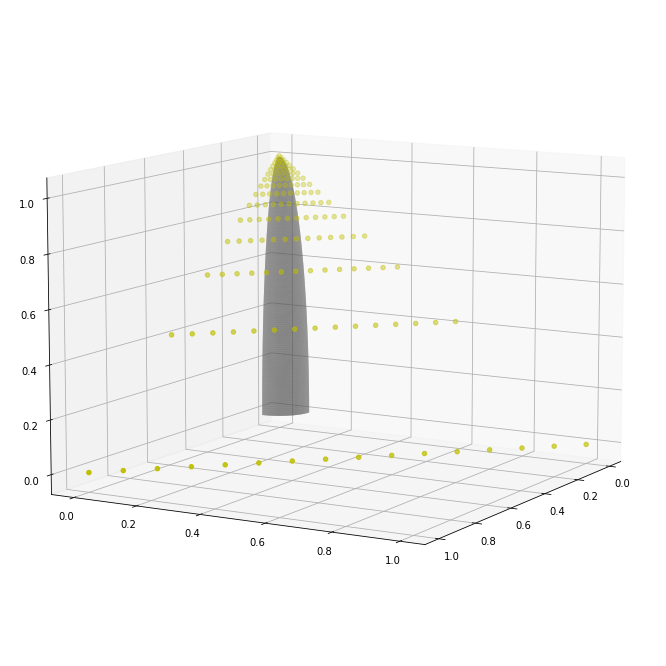

In [213]:
fig = plt.figure(figsize=(12, 12))
stride=1
u = np.linspace(0, np.pi/2, 200)
v = np.linspace(0, np.pi/2, 200)
r = 1
x = r*np.outer(np.cos(u), np.sin(v))
y = r*np.outer(np.sin(u), np.sin(v))
z = r*np.outer(np.ones(np.size(u)), np.cos(v))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a*x*0.998, b*y*0.998, c*z*0.998, color = '#faf7f8', cstride=stride, rstride=stride)
ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2],color='y')
ax.view_init(elev=10., azim=30)

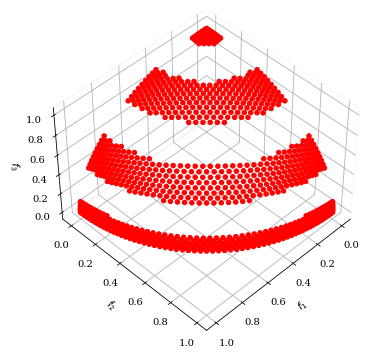

In [10]:
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=60)
pf = get_problem("mw8").pareto_front(ref_dirs)
Scatter(angle=(45,45)).add(pf, color="red").show()